In [18]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
import pymaster as nmt
from scipy.optimize import minimize_scalar, minimize
import camb

from mass_maping import kaiser_squire
from utils import sigma8_difference, apply_random_rotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Computation of pseudo-Cls using DES data

In [19]:
des_cat = fits.getdata('/n17data/mkilbing/astro/data/DES/DES_Y3_cut.fits') 

In [20]:
e1_cal = (des_cat['e1'] - np.average(des_cat['e1'], weights=des_cat['w']))/np.average(des_cat['R11'])
e2_cal = (des_cat['e2'] - np.average(des_cat['e2'], weights=des_cat['w']))/np.average(des_cat['R22'])

In [21]:
nside = 512

theta = (90 - des_cat['dec'])*np.pi/180
phi = des_cat['ra']*np.pi/180
pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
n_gal = np.zeros(hp.nside2npix(nside))
n_gal[unique_pix] += np.bincount(idx_rep, weights=des_cat['w'])
mask = n_gal != 0

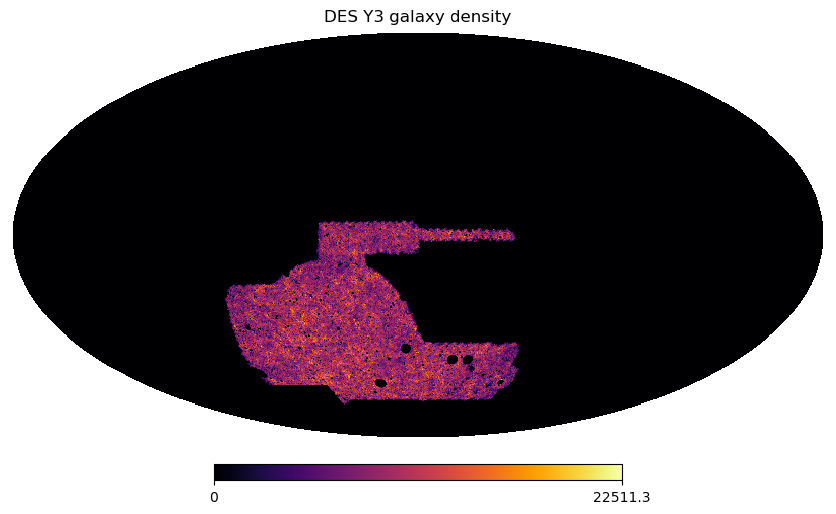

In [22]:
hp.mollview(n_gal, title='DES Y3 galaxy density', cmap='inferno')
plt.show()

In [23]:
gamma_obs_e1 = np.zeros(hp.nside2npix(nside))
gamma_obs_e2 = np.zeros(hp.nside2npix(nside))

gamma_obs_e1[unique_pix] += np.bincount(idx_rep, weights=e1_cal*des_cat['w'])
gamma_obs_e2[unique_pix] += np.bincount(idx_rep, weights=e2_cal*des_cat['w'])

gamma_obs_e1[mask] /= n_gal[mask]
gamma_obs_e2[mask] /= n_gal[mask]

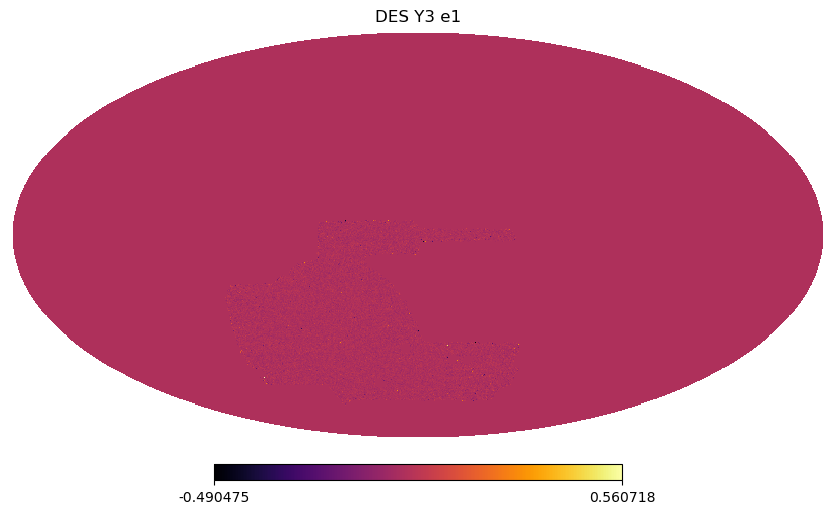

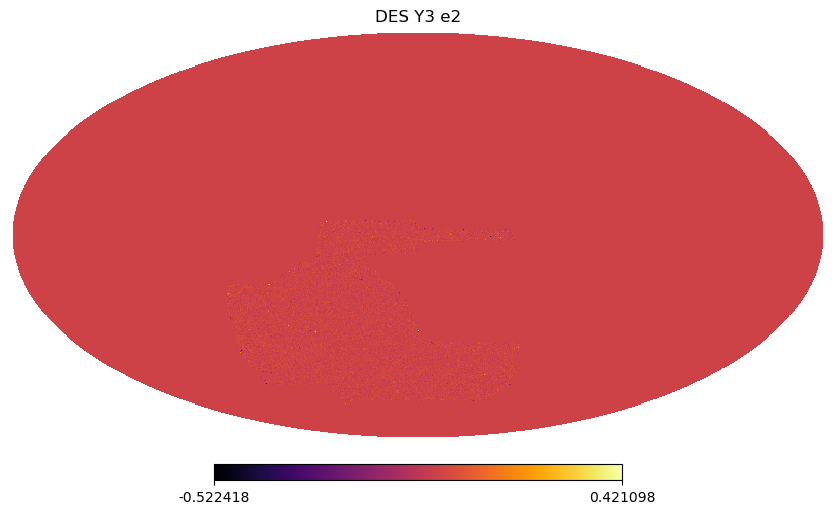

In [24]:
hp.mollview(gamma_obs_e1, title='DES Y3 e1', cmap='inferno')
plt.show()

hp.mollview(gamma_obs_e2, title='DES Y3 e2', cmap='inferno')
plt.show()

In [25]:
kappa_map_E, kappa_map_B = kaiser_squire(gamma_obs_e1 +1j* gamma_obs_e2)

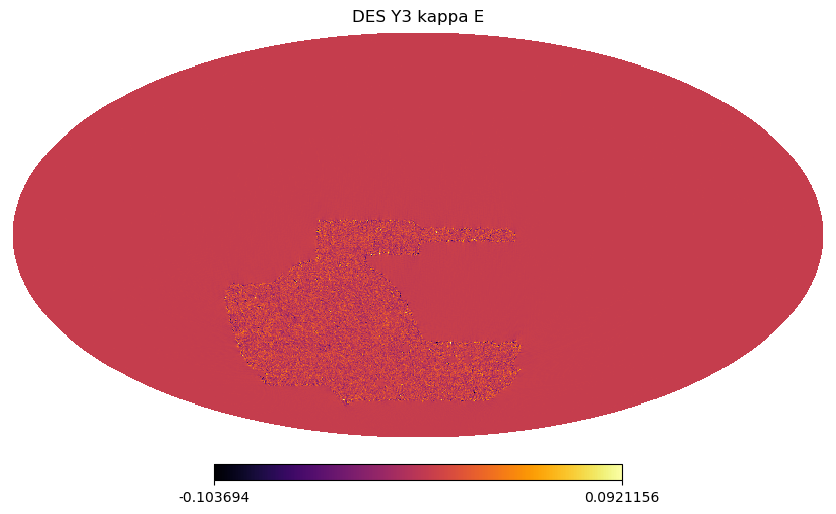

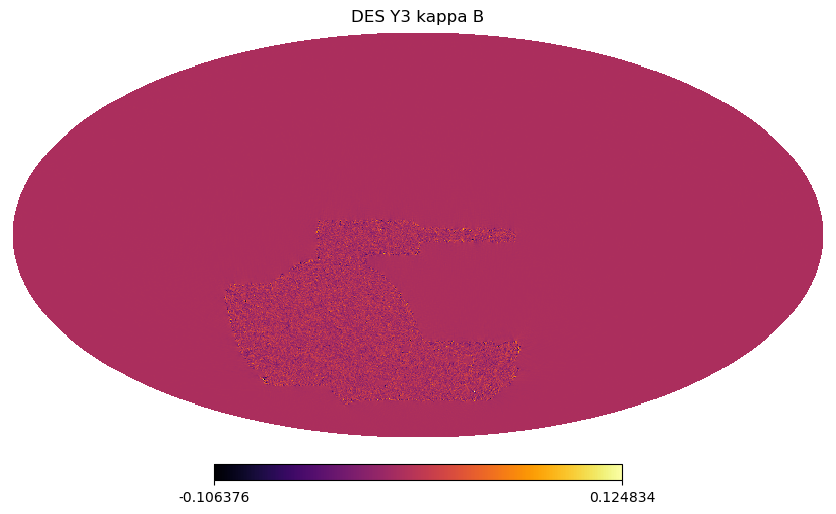

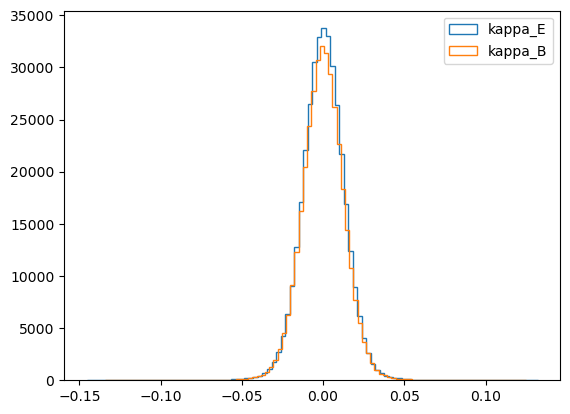

In [26]:
hp.mollview(kappa_map_E, title='DES Y3 kappa E', cmap='inferno')
plt.show()

hp.mollview(kappa_map_B, title='DES Y3 kappa B', cmap='inferno')
plt.show()

plt.figure()

plt.hist(kappa_map_E[mask], bins=100, histtype='step', label='kappa_E')
plt.hist(kappa_map_B[mask], bins=100, histtype='step', label='kappa_B')
plt.legend()

plt.show()

## Computation of the pseudo-Cl's

In [27]:
f = nmt.NmtField(mask, [gamma_obs_e1, -gamma_obs_e2])

b = nmt.NmtBin.from_nside_linear(nside, 10)

cl = nmt.compute_full_master(f, f, b)

In [28]:
dndz, z = np.histogram(des_cat['zmc_sof'][des_cat['zmc_sof']>=0], bins=200, density=True)
z = 0.5*(z[1:] + z[:-1])

z_mode = 0.4390
alpha = 2
beta = 2
dndz_smail = (z/z_mode)**(alpha)*np.exp(-(z/z_mode)**beta)
dndz_smail /= np.trapz(dndz_smail, z)

def objective(params, z, dndz_target):
    z_mode, alpha, beta = params
    dndz = (z/z_mode)**(alpha)*np.exp(-(z/z_mode)**beta)
    dndz /= np.trapz(dndz, z)
    return np.sum((dndz - dndz_target)**2)

res_dndz = minimize(objective, args=(z, dndz), x0=(z_mode, alpha, beta))

In [29]:
print(res_dndz)

dndz_smail = (z/res_dndz.x[0])**(res_dndz.x[1])*np.exp(-(z/res_dndz.x[0])**res_dndz.x[2])
dndz_smail /= np.trapz(dndz_smail, z)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2922209485026321
        x: [ 8.929e-01  1.004e+00  2.855e+00]
      nit: 17
      jac: [-3.129e-07 -4.470e-08  2.980e-08]
 hess_inv: [[ 1.013e-01 -2.176e-01  6.143e-01]
            [-2.176e-01  5.460e-01 -1.267e+00]
            [ 6.143e-01 -1.267e+00  4.123e+00]]
     nfev: 84
     njev: 21


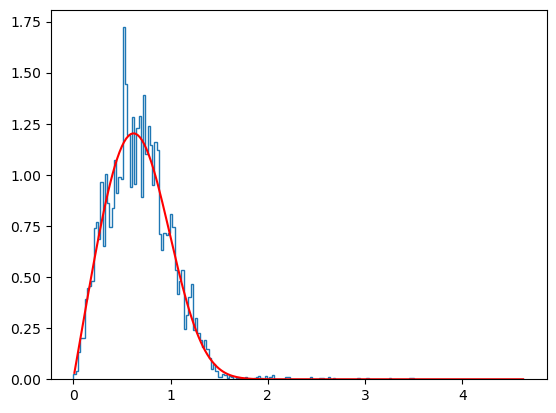

In [30]:
plt.figure()

plt.hist(des_cat['zmc_sof'][des_cat['zmc_sof']>=0], bins=200, histtype='step', label='DES Y3', density=True)
plt.plot(z, dndz_smail, label='Smail', color='red')

plt.show()

In [36]:
#Theory from DES Y3 paper (Doux et al.)
nside = 512
lmax = 2*nside

ell = np.arange(1, lmax)

Om = 0.260
sigma_8 = 0.863
h = 0.7
Ob = 0.05
ns = 0.96
m_nu = 0.06
w = -1
Oc = Om - Ob

cosmo_params = {}
cosmo_params['h'] = h
cosmo_params['Omega_m'] = Om
cosmo_params['Omega_b'] = Ob
cosmo_params['n_s'] = ns
cosmo_params['m_nu'] = m_nu
cosmo_params['w'] = w
cosmo_params["sigma_8"] = sigma_8

res = minimize_scalar(sigma8_difference, args=(cosmo_params,), bracket=[np.log(1e-9), np.log(3e-9)], tol=1e-10)
cosmo_params["A_s"] = np.exp(res.x)

As = cosmo_params["A_s"]

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

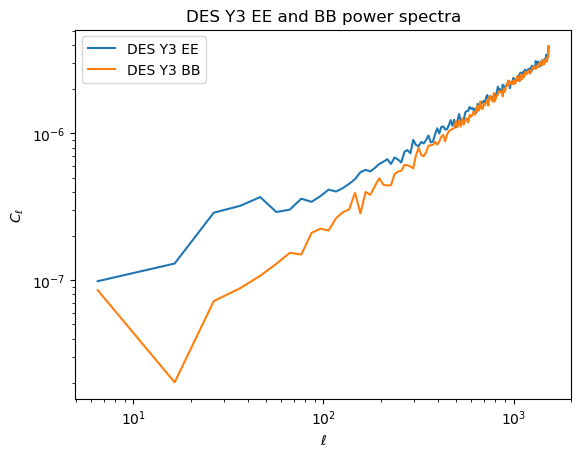

In [32]:
plt.figure()

ell_eff = b.get_effective_ells()

ell = np.arange(lmax+1)
#get the healpix window function
pw = hp.pixwin(nside, lmax=lmax)

plt.plot(ell_eff, ell_eff*cl[0], label='DES Y3 EE')
plt.plot(ell_eff, ell_eff*cl[3], label='DES Y3 BB')
#plt.plot(ell, ell*theory_cls['W1xW1']*pw**2, label='CAMB')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.title('DES Y3 EE and BB power spectra')

plt.show()

## Computation of the binned noise power spectrum

In [33]:
area = np.sum(mask)*hp.nside2pixarea(nside, degrees=True)
print(f"Area: {area} deg^2")
area_pix = hp.nside2pixarea(nside)
print(f"Area per pixel: {area_pix} str")

Area: 4863.654218145886 deg^2
Area per pixel: 3.994741635118857e-06 str


In [34]:
binned_noise = np.zeros(hp.nside2npix(nside))
_w = des_cat['w'] * float(len(des_cat))/np.sum(des_cat['w'])

pix_bn = hp.ang2pix(nside, theta, phi)

unique_pix_bn, idx_bn, idx_rep_bn = np.unique(pix_bn, return_index=True, return_inverse=True)

weight_binned_noise = 0.5*_w**2*(e1_cal**2 + e2_cal**2)
binned_noise[unique_pix_bn] += np.bincount(idx_rep_bn, weights=weight_binned_noise)
weight_sq_map[unique_pix_bn] += np.bincount(idx_rep_bn, weights=des_cat['w']**2)

NameError: name 'weight_sq_map' is not defined

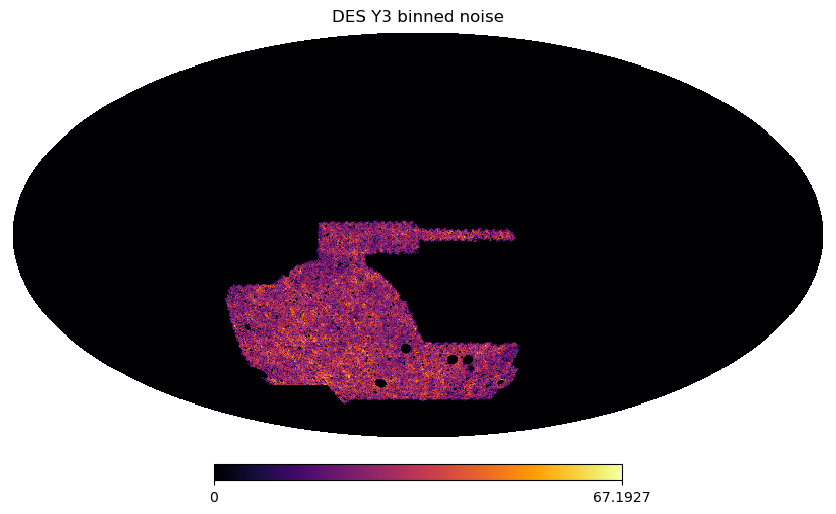

In [ ]:
hp.mollview(binned_noise, title='DES Y3 binned noise', cmap='inferno')
plt.show()

In [ ]:
cl_th_noise = area_pix * np.average(binned_noise)
print(f"Binned noise: {cl_th_noise}")

Binned noise: 1.233559318617352e-05


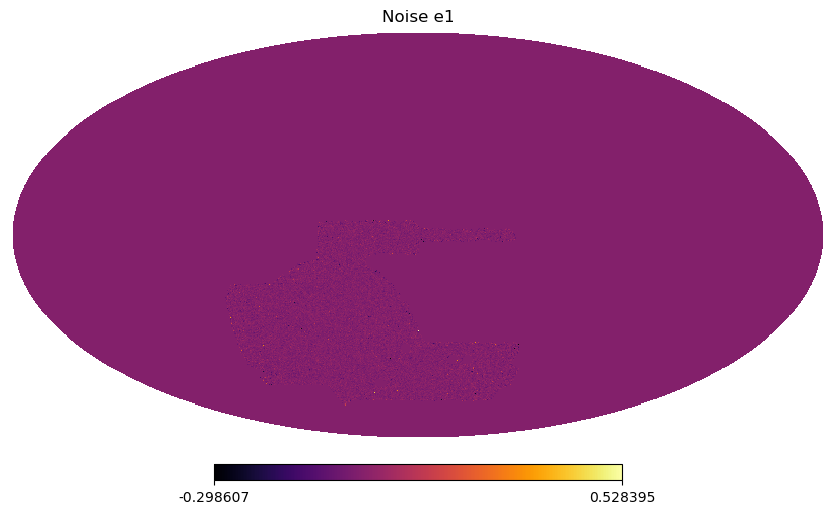

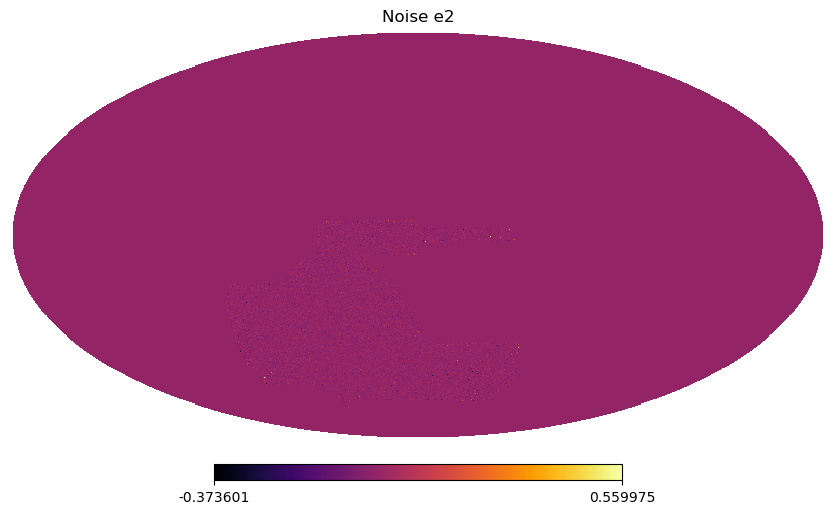

In [ ]:
#Build a noise map by applying random rotations to the observed ellipticities
e1_rot, e2_rot = apply_random_rotation(e1_cal, e2_cal)

noise_map = np.zeros(hp.nside2npix(nside))
noise_e1 = np.zeros(hp.nside2npix(nside))
noise_e2 = np.zeros(hp.nside2npix(nside))

noise_map[unique_pix] += np.bincount(idx_rep, weights=des_cat['w'])
noise_e1[unique_pix] += np.bincount(idx_rep, weights=e1_rot*des_cat['w'])
noise_e2[unique_pix] += np.bincount(idx_rep, weights=e2_rot*des_cat['w'])

noise_e1[mask] /= noise_map[mask]
noise_e2[mask] /= noise_map[mask]

hp.mollview(noise_e1, title='Noise e1', cmap='inferno')
plt.show()

hp.mollview(noise_e2, title='Noise e2', cmap='inferno')
plt.show()

In [ ]:
f_noise = nmt.NmtField(mask, [noise_e1, noise_e2])

b = nmt.NmtBin.from_nside_linear(nside, 10)

cl_noise = nmt.compute_full_master(f_noise, f_noise, b)

In [ ]:
cl_noise

array([[ 3.08875203e-09,  1.98172647e-09,  2.49066407e-09,
         2.43604309e-09,  2.22049105e-09,  2.31544882e-09,
         1.84724280e-09,  1.90990374e-09,  2.28541789e-09,
         2.18744705e-09,  2.06476220e-09,  2.47580500e-09,
         2.14774087e-09,  2.21381305e-09,  2.63313076e-09,
         2.06137035e-09,  2.29064439e-09,  2.33693387e-09,
         2.24546871e-09,  2.17674060e-09,  2.23138360e-09,
         2.40281654e-09,  2.14654990e-09,  2.34298038e-09,
         2.53021524e-09,  2.29247439e-09,  2.51444027e-09,
         2.30483723e-09,  2.46901428e-09,  2.06614376e-09,
         2.09843014e-09,  2.21766857e-09,  2.32735293e-09,
         2.10478249e-09,  2.34563225e-09,  2.16763307e-09,
         2.23375093e-09,  2.32587276e-09,  2.22094329e-09,
         2.28908852e-09,  2.27378294e-09,  2.17040502e-09,
         2.30593153e-09,  2.19181981e-09,  2.16042964e-09,
         2.29208013e-09,  2.00680374e-09,  2.30475518e-09,
         2.13685785e-09,  2.27431450e-09,  2.30301668e-0

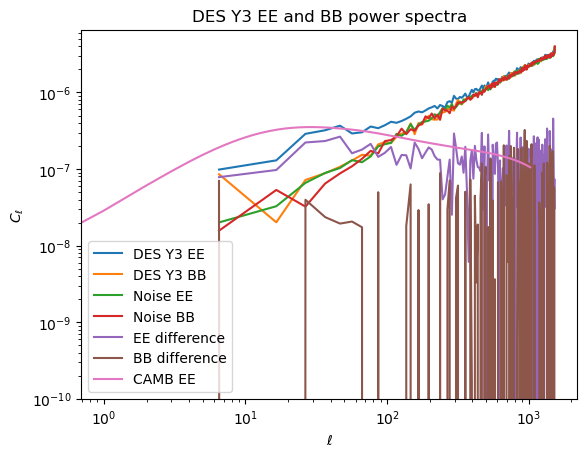

In [ ]:
plt.figure()

ell_eff = b.get_effective_ells()

ell = np.arange(lmax+1)
#get the healpix window function
pw = hp.pixwin(nside, lmax=lmax)

plt.plot(ell_eff, ell_eff*cl[0], label='DES Y3 EE')
plt.plot(ell_eff, ell_eff*cl[3], label='DES Y3 BB')
plt.plot(ell_eff, ell_eff*cl_noise[0], label='Noise EE')
plt.plot(ell_eff, ell_eff*cl_noise[3], label='Noise BB')
cl_diff_EE = cl[0] - cl_noise[0]
cl_diff_BB = cl[3] - cl_noise[3]
plt.plot(ell_eff, ell_eff*cl_diff_EE, label='EE difference')
plt.plot(ell_eff, ell_eff*cl_diff_BB, label='BB difference')
plt.plot(ell, ell*theory_cls['W1xW1']*pw**2, label='CAMB EE')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.title('DES Y3 EE and BB power spectra')

plt.show()